In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from importlib import reload

import xarray as xr
import xnemogcm as xn
import xgcm

from pyCDFTOOLS import analysis, in_out
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# try opening
base_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"  # mesh_mask lives here
data_dir = base_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/"

domcfg = xn.open_domain_cfg(base_dir)

# opening file already in _grid_T.nc convention; going to load everything into one object
ds = xn.open_nemo_and_domain_cfg(
    domcfg_files=base_dir,
    nemo_files=[data_dir + "UNAGI_10y_08010101_08101230_grid_T.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_U.nc",
                data_dir + "UNAGI_10y_08010101_08101230_grid_V.nc"]
)

# open files not in the _grid_T.nc convention (note domcfg goes AFTER positions here)
ds_1y = xn.process_nemo(
    positions=[
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_T.nc"), 'T'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_U.nc"), 'U'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_V.nc"), 'V'),
    ],
    domcfg=domcfg,
)

# could merge into one if you want (depends if you want multiple objects floating around)
# warning: if "t_bound" clash, then at risk of the ds data variables being killed (NaNs)
# ds = ds.merge(ds_1y, compat="override")
# del ds_1  # free up the object

In [3]:
# generate the grid object

Static_e3 = True
metrics_dict = xn.get_metrics(ds)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
grid = xgcm.Grid(ds, metrics=metrics_dict, periodic=["X"])  # specify periodicity with a list

bd = {'boundary':'fill', 'fill_value':0}

### cdfcurl (vorticity)

=== WARNING: no z_c information found, assume it is a T-grid variable ===


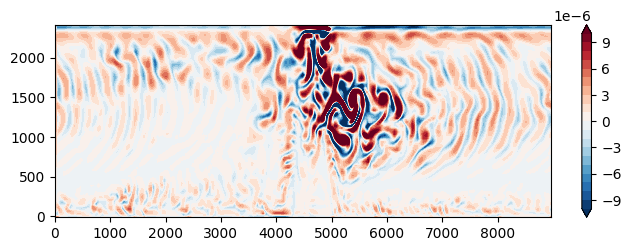

In [4]:
reload(analysis)

# there are NaN's in the data for some reason...? 
# pass data per time frame (in line with t_bound in ds; ugly, to tidy)
xi = analysis.cdfcurl(grid, ds, ds_1y.ssu_inst.isel(t=2), ds_1y.ssv_inst.isel(t=2), **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(xi.glam[:, :-1], xi.gphi[:, :-1], xi[:, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [5]:
# test write of data (promote to dataset first)
# in_out.save_netcdf(xi)

variable name socurl, output to socurl.nc


## cdfmoc (averaging at fixed depth)

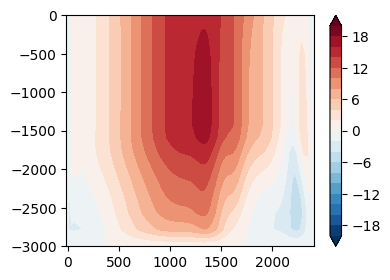

In [6]:
# reload(analysis)

moc = analysis.cdfmoc(grid, ds, ds.voce.isel(t=0), **bd)

# problem near the periodic boundary outputs at 0 and -1, just don't use it for now...
# great big deep reaching (unphysical) Deacon cell, as expected

fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
cs = ax.contourf(moc.gphi, -moc.gdep, moc,
                 levels=np.linspace(-20, 20, 21), cmap="RdBu_r", extend="both") 
plt.colorbar(cs)

## cdfzonalmean (along i-direction)

/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_3171707/4087958298.py:7: UserWarning: The following kwargs were not used by contour: 'linestyle'
  axs[0].contour(dum.gphi, -dum.gdep, dum.isel(t=0), 20, colors='k', linestyle='--')
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jclmak/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, '$\\overline{v}$')

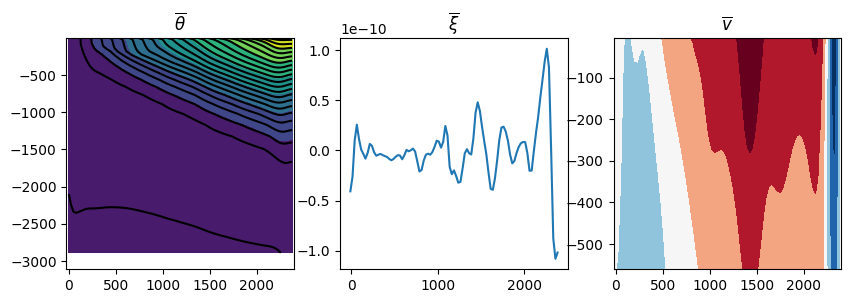

In [7]:
# reload(analysis)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

dum = analysis.cdfzonalmean(grid, ds, ds.toce, **bd)
axs[0].contourf(dum.gphi, -dum.gdep, dum.isel(t=0))
axs[0].contour(dum.gphi, -dum.gdep, dum.isel(t=0), 20, colors='k', linestyle='--')
axs[0].set_title(r"$\overline{\theta}$")

dum = analysis.cdfzonalmean(grid, ds, xi, **bd)
axs[1].plot(dum.gphi, dum)
axs[1].set_title(r"$\overline{\xi}$")

dum = analysis.cdfzonalmean(grid, ds, ds.uoce[:, 0:15, :, :], **bd)
axs[2].contourf(dum.gphi, -dum.gdep, dum.isel(t=0), cmap="RdBu_r", extend="both")
axs[2].set_title(r"$\overline{v}$")


In [16]:
dum.gdept_1d.values

array([16.84938306, 30.48358716])

In [21]:
mask = ds.fmask[
da.z_c.values

array(0)

In [9]:
dum

<xarray.DataArray (y_f: 98)>
dask.array<truediv, shape=(98,), dtype=float64, chunksize=(98,), chunktype=numpy.ndarray>
Coordinates:
  * y_f       (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 93.5 94.5 95.5 96.5 97.5
    z_c       int64 0
    gdept_1d  float64 dask.array<chunksize=(), meta=np.ndarray>
    x_f       float64 1.5
    glamf     (y_f) float64 dask.array<chunksize=(98,), meta=np.ndarray>
    gphif     (y_f) float64 dask.array<chunksize=(98,), meta=np.ndarray>
Attributes:
    standard_name:  socurl
    long_name:      Relative_vorticity (curl)
    units:          s-1

In [7]:
xi.coords

Coordinates:
  * x_f       (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y_f       (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 93.5 94.5 95.5 96.5 97.5
    glamf     (y_f, x_f) float64 dask.array<chunksize=(98, 360), meta=np.ndarray>
    gphif     (y_f, x_f) float64 dask.array<chunksize=(98, 360), meta=np.ndarray>
    z_c       int64 0
    gdept_1d  float64 dask.array<chunksize=(), meta=np.ndarray>